# Venta de Viviendas en Seattle; ML - Gradient Boosting Regression.

## Introducción

No conformes con la obtención de un buen resultado con un modelo tradicional, adicionalmente se probará con algún modelo de los denominados ensamblados, basados en arboles de decisión. Debido a que tenemos variables categoricas en nuestro dataset, se empleará con el CatBoost, un modelo tipo gradient boosting que no es sensible a la presencia de variables categóricas en neustro dataframe, y no es necesario transformar dichas variables con algún Encoding, para facilitar este último apartado adicional.

## Modelo Gradient Boosting Regressor (CatBoost)

Importamos y cargamos las librerías necesarias para trabajar.

In [1]:
# Procesamiento y visualizacion de datos.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modelado
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Enssemble
from catboost import CatBoostRegressor

# Otros
import json

Leemos el archivo .csv guardado con el dataset depurado.

In [2]:
df = pd.read_csv('C:/Users/jeje9/Projects/Housing Sales Seattle/data/freeze_data/df_imputed_trf.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   quarter      5000 non-null   int64  
 1   Luxury       5000 non-null   int64  
 2   floors       5000 non-null   int64  
 3   bedrooms     5000 non-null   object 
 4   bathrooms    5000 non-null   object 
 5   basement     5000 non-null   int64  
 6   view         5000 non-null   int64  
 7   waterfront   5000 non-null   int64  
 8   condition    5000 non-null   object 
 9   sqft_lot     5000 non-null   float64
 10  sqft_living  5000 non-null   float64
 11  sqft_above   5000 non-null   float64
 12  yr_built     5000 non-null   object 
 13  renovated    5000 non-null   int64  
 14  lat          5000 non-null   float64
 15  long         5000 non-null   float64
 16  price        5000 non-null   float64
dtypes: float64(6), int64(7), object(4)
memory usage: 664.2+ KB


Hagamos unos pequeños ajustes en la tipología de las variables.

In [4]:
for i in df.columns:
    if df[i].nunique() < 4:
        df[i] = df[i].astype('category')

Separamos variables predictoras de la objetivo.

In [5]:
features = df.select_dtypes(include=['number', 'object', 'category']).columns.tolist()

features = [col for col in features if col != 'price']

In [6]:
X = df[features]
y = df['price']

Además, debemos extraer los índices de las variables categóricas para indicarselas al modelo CatBoost.

In [7]:
cat_cols = df.select_dtypes(include = ['category']).columns

cat_index = [df.columns.get_loc(i) for i in cat_cols]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=61)

Previamente a aplicar un modelo cualquiera, usemos la librería GridSearch para buscar cuales son los mejores parámetros para aplicar en nuestro modelo CatBoost.

In [9]:
model = CatBoostRegressor(cat_features = cat_index, silent=True)

Display de parámetros a valorar como adecuados para nuestro modelo.

In [10]:
param_grid = {
    'learning_rate': [0.01, 0.5, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100, 200, 300]
}

In [ ]:
#grid_search = GridSearchCV(
#    estimator=model,
#    param_grid=param_grid,
#    cv=3,
#    scoring='neg_root_mean_squared_error', #MSE
#    n_jobs=-1)

#grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000269FA19CDA0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 300],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.01, 0.5, 0.1]},
             scoring='neg_root_mean_squared_error')

Para evitar los 7 minutos que me ha durado en mi PC ejecutar el GridSearch, lo dejo comentado y guardo el set de mejores parámetros en best_params.json, así se puede leer directamente desde ahí como diccionario para usar en el modelo.

In [ ]:
#best_params = grid_search.best_params_

with open("best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)

In [13]:
print(best_params)

{'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


In [14]:
with open("best_params.json", "r") as f:
    best_params = json.load(f)

Aplicamos el modelo CatBoostRegressor con RMSE en loss_function, así el modelo intenta minimizar esta métrica durante el entrenamiento, lo que significa que el objetivo del modelo es reducir el error cuadrático medio entre las predicciones y los valores reales, de esta manera permite al modelo ajustarse para hacer predicciones lo más precisas posible. Respecto al resto de hiperparámetros, utilizamos los dados por GridSearch.

In [15]:
model = CatBoostRegressor(
    **best_params,       
    cat_features = cat_index,
    loss_function='RMSE',
    silent=True)

In [16]:
model.fit(X_train, y_train, verbose=False)

y_pred = model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)
r2 = model.score(X_test, y_test) 

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 0.007415945741004146
R²: 0.88449377495921


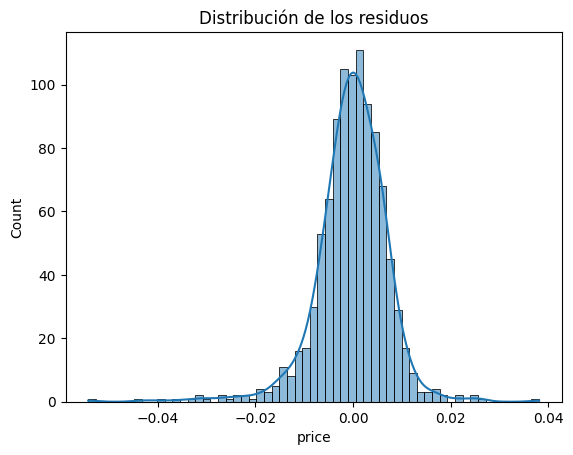

In [18]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Distribución de los residuos")
plt.show()

También podemos ver cuanto se han alejado las predicciones de la realidad con un gráfico de dispersión.

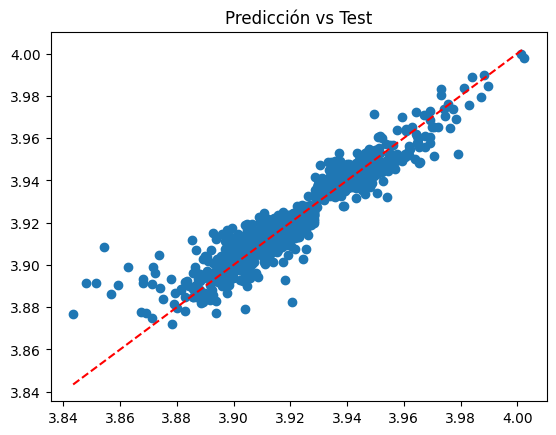

In [19]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'red', linestyle = '--')
plt.title("Predicción vs Test")
plt.show()

Observemos también cuales son las variables que más importancia tienen en el modelo.

In [20]:
importances = model.get_feature_importance()

In [21]:
importances_df = pd.DataFrame({
    'Feature': model.feature_names_,
    'Importance': importances
})

In [22]:
print(importances_df.sort_values(by='Importance', ascending=False))

        Feature  Importance
1        Luxury   28.165261
14          lat   27.007812
10  sqft_living   14.012055
15         long    9.782269
11   sqft_above    8.834908
9      sqft_lot    3.426770
6          view    1.657877
5      basement    1.541039
8     condition    1.316380
7    waterfront    0.815947
4     bathrooms    0.784127
12     yr_built    0.779730
2        floors    0.671203
0       quarter    0.643004
13    renovated    0.367022
3      bedrooms    0.194595


Con el CatBoost obtenemos un RMSE = 0.007 (no olvidemos que seguimos arrastrando la variable objetivo transformada), un valor bajo con el que nuestro modelo realiza predicciones muy cercanas a los valores reales, además, se incrementa notoriamente el R². Esta mejora respecto a la regresión lineal, viene dada por la captación de no linealidades del modelo CatBoost que la regresión lineal no es capaz.

Analizando los residuos de igual forma que en la regresión lineal, el modelo CatBoost sigue teniendo dificultades para predecir correctamente los valores reales bajos de la variable objetivo en test, esto se puede contrastar en el gráfico de dispersión.

## Autor: Alfonso Guisado González